# Zipline Backtest with Single Factor 

Test a simple mean-reversion factor that measures how much recent performance has deviated from the historical average. Short-term reversal is a common strategy that takes advantage of the weakly predictive pattern that stock price increases are likely to mean-revert back down over horizons from less than a minute to one month.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
import os
environ = os.environ

from trading_calendars import get_calendar
#loading and setting the calendar
trading_calendar = get_calendar('NYSE')

Run using jupyter notebook extension

In [4]:
%load_ext zipline

Using the `quandl` bundle instead of the default `quantopian-quandl` because the latter has a bug that requires (manually) fixing the SQL database. If you have a file with benchmark returns you can provide this instead of `--no-benchmark` (see [docs](https://github.com/stefan-jansen/zipline/blob/master/docs/source/whatsnew/1.4.0.txt)).

In [5]:
%%zipline --start 2014-1-1 --end 2021-10-1 --no-benchmark --bundle yahoo_direct

from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd
from trading_calendars import get_calendar
#loading and setting the calendar
trading_calendar = get_calendar('NYSE')
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000

import os
from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)

    
    

def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')

,period_open,period_close,starting_exposure,net_leverage,returns,ending_exposure,starting_value,ending_value,starting_cash,ending_cash,...,max_leverage,excess_return,treasury_period_return,trading_days,period_label,algo_volatility,benchmark_period_return,benchmark_volatility,factor_data,prices
2014-01-02 21:00:00+00:00,2014-01-02 14:31:00+00:00,2014-01-02 21:00:00+00:00,0.000,0.000000,0.000000,0.000,0.000,0.000,1.000000e+07,1.000000e+07,...,0.000000,0.0,0.0,1,2014-01,NaN,0.0,NaN,NaN,NaN
2014-01-03 21:00:00+00:00,2014-01-03 14:31:00+00:00,2014-01-03 21:00:00+00:00,0.000,0.000000,0.000000,0.000,0.000,0.000,1.000000e+07,1.000000e+07,...,0.000000,0.0,0.0,2,2014-01,0.000000,0.0,0.0,NaN,NaN
2014-01-06 21:00:00+00:00,2014-01-06 14:31:00+00:00,2014-01-06 21:00:00+00:00,0.000,0.000000,0.000000,0.000,0.000,0.000,1.000000e+07,1.000000e+07,...,0.000000,0.0,0.0,3,2014-01,0.000000,0.0,0.0,Equity(0 [BLK]) 3.0 Equity(1 [MSFT]) ...,Equity(0 [BLK]) 314.070 Equity(1 [MSFT]) ...
2014-01-07 21:00:00+00:00,2014-01-07 14:31:00+00:00,2014-01-07 21:00:00+00:00,0.000,0.323396,-0.000167,3233420.534,0.000,3233420.534,1.000000e+07,6.764913e+06,...,0.323396,0.0,0.0,4,2014-01,0.001323,0.0,0.0,Equity(0 [BLK]) 3.0 Equity(1 [MSFT]) ...,Equity(0 [BLK]) 314.070 Equity(1 [MSFT]) ...
2014-01-08 21:00:00+00:00,2014-01-08 14:31:00+00:00,2014-01-08 21:00:00+00:00,3233420.534,0.323346,-0.000074,3232684.477,3233420.534,3232684.477,6.764913e+06,6.764913e+06,...,0.323396,0.0,0.0,5,2014-01,0.001168,0.0,0.0,Equity(0 [BLK]) 3.0 Equity(1 [MSFT]) ...,Equity(0 [BLK]) 314.070 Equity(1 [MSFT]) ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27 20:00:00+00:00,2021-09-27 13:31:00+00:00,2021-09-27 20:00:00+00:00,7224284.870,0.328180,0.001285,7252651.850,7224284.870,7252651.850,1.484699e+07,1.484699e+07,...,0.362182,0.0,0.0,1948,2021-09,0.075846,0.0,0.0,Equity(0 [BLK]) 8.0 Equity(1 [MSFT]) ...,Equity(0 [BLK]) 875.47 Equity(1 [MSFT]) ...
2021-09-28 20:00:00+00:00,2021-09-28 13:31:00+00:00,2021-09-28 20:00:00+00:00,7252651.850,0.235119,-0.010830,5139771.110,7252651.850,5139771.110,1.484699e+07,1.672054e+07,...,0.362182,0.0,0.0,1949,2021-09,0.075935,0.0,0.0,Equity(0 [BLK]) 8.0 Equity(1 [MSFT]) ...,Equity(0 [BLK]) 875.47 Equity(1 [MSFT]) ...
2021-09-29 20:00:00+00:00,2021-09-29 13:31:00+00:00,2021-09-29 20:00:00+00:00,5139771.110,0.234638,-0.000629,5126028.850,5139771.110,5126028.850,1.672054e+07,1.672054e+07,...,0.362182,0.0,0.0,1950,2021-09,0.075916,0.0,0.0,Equity(0 [BLK]) 8.0 Equity(1 [MSFT]) ...,Equity(0 [BLK]) 875.47 Equity(1 [MSFT]) ...
2021-09-30 20:00:00+00:00,2021-09-30 13:31:00+00:00,2021-09-30 20:00:00+00:00,5126028.850,0.234648,0.000013,5126312.300,5126028.850,5126312.300,1.672054e+07,1.672054e+07,...,0.362182,0.0,0.0,1951,2021-09,0.075897,0.0,0.0,Equity(0 [BLK]) 8.0 Equity(1 [MSFT]) ...,Equity(0 [BLK]) 875.47 Equity(1 [MSFT]) ...


## Inspect Results

We can get the result `DataFrame` using `_` which captures the last cell output (only works when you run it right after the above cell)

In [6]:
result = _

In [7]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1952 entries, 2014-01-02 21:00:00+00:00 to 2021-10-01 20:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              1952 non-null   datetime64[ns, UTC]
 1   period_close             1952 non-null   datetime64[ns, UTC]
 2   starting_exposure        1952 non-null   float64            
 3   net_leverage             1952 non-null   float64            
 4   returns                  1952 non-null   float64            
 5   ending_exposure          1952 non-null   float64            
 6   starting_value           1952 non-null   float64            
 7   ending_value             1952 non-null   float64            
 8   starting_cash            1952 non-null   float64            
 9   ending_cash              1952 non-null   float64            
 10  portfolio_value          1952 non-null   float64

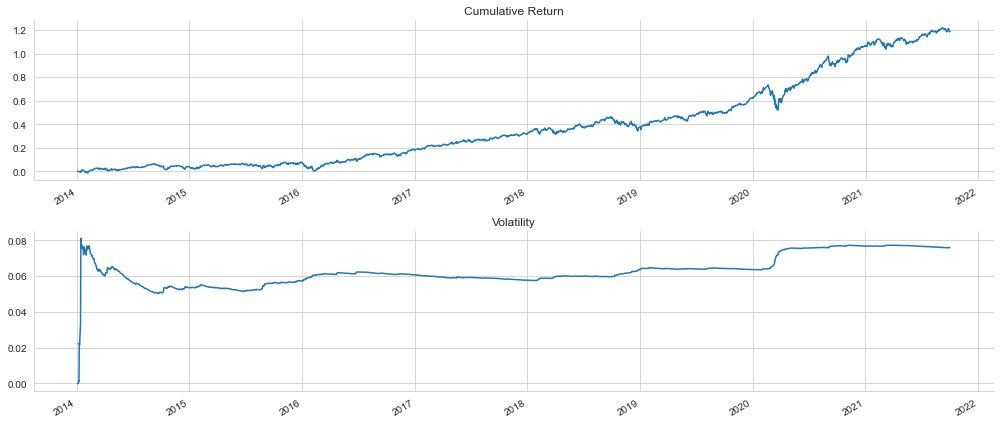

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(14,6))
result.algorithm_period_return.plot(ax=axes[0], title='Cumulative Return')
result.algo_volatility.plot(ax=axes[1], title='Volatility')
sns.despine()
fig.tight_layout()
fig.savefig(('results/simple_mean_reversion_pipeline_results'), dpi=300);

In [11]:
result.to_csv("results/results.csv")